# Magma ocean thermal evolution model
by Maxime Maurice (maxime.maurice@rice.edu)

### Dependencies and Packages

In [1]:
from physics import eos,viscosity
from physics.phase_change.refractories import mc_book
from chemistry.elements import *
from chemistry.molecules import *
from chemistry.equilibria import *
from chemistry.redox import *
from datapath import datapath
from magma_ocean import magma_ocean
from atmospheres import atmosphere, multi_species_single_condensible_convective_atmosphere
from petitRADTRANS import Radtrans
from utils import y2s
import matplotlib.pyplot as plt

%matplotlib inline

### case-specific settings

In [2]:
eq_C.coefs[O2]      = 0 # Small hack, becaus eO2 is not conserved but fO2 is fixed,
eq_H.coefs[O2]      = 0 # so we put it in the equilibrium constant later

albedo              = 0.2
faint_young_sun     = 0.75
solar_const         = 1367.6 # [W/m^2]
stellar_irradiation = 1./4*solar_const*(1.-albedo)*faint_young_sun

R_planet            = 6371000 # [m]
g_planet            = 9.798 # [m/s^2]
BSE_mass            = 4e24 # [kg]
EO_mass             = 1.4e21  # [kg]

T_pot               = 3003 # [K] arbitrary initial value (will be updated later)
p_CMB               = 135e9 # [Pa]

BSE                 = pd.read_excel(datapath+'/BSE_composition.ods',index_col=0,sheet_name='molar').T['Palme and Oneill 2003'] # molar fractions

## Magma Ocean

### Prepare EOS

In [3]:
from burnman.minerals.DKS_2013_liquids import MgSiO3_liquid
# Equations of state for MgSiO3 liquid [de Koker and Stixrude 2013]

rho   = lambda p,T:MgSiO3_liquid().evaluate(['density'],p,T)
alpha = lambda p,T:MgSiO3_liquid().evaluate(['thermal_expansivity'],p,T)
cp    = lambda p,T:MgSiO3_liquid().evaluate(['C_p'],p,T)/MgSiO3_liquid().molar_mass

# Need to vectorize: burnman struggles otherwise
rho_vec   = np.vectorize(rho)
alpha_vec = np.vectorize(alpha)
cp_vec    = np.vectorize(cp)

### Create Magma ocean

In [4]:
MO = magma_ocean(T_pot,
                 p_CMB, # for fractional crystallization cases, we have to make the MO believe that 
                 eos={'rho':rho_vec,'alpha':alpha_vec,'cp':cp_vec},
                 g=g_planet,
                 R=R_planet,
                 ConvCum=True)

### melting curves

Text(0, 0.5, 'pressure [GPa]')

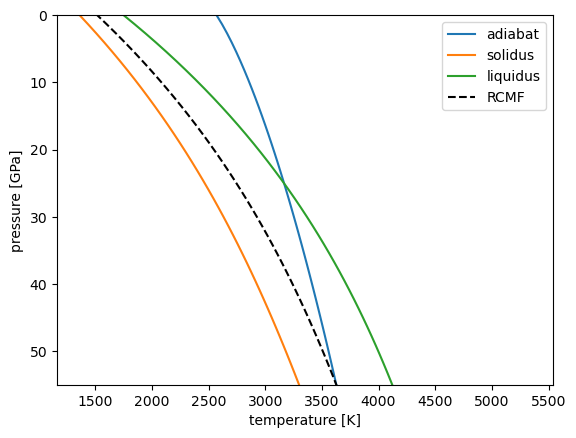

In [5]:
MO.setMeltingCurves(mc_book['Earth'],file=datapath+'/mc_lookups_equi_RCMF=0.4_MgSiO3_liquid_EOS.dat',RCMF=0.4)
#MO.setMeltingCurves(mc_book['Earth'],RCMF=0.4,p_bot0=55e9)

# initialize potential temperature
MO.updateT_pot(MO.T_pot_lookup[np.argmin(abs(MO.p_bot_lookup-55e9))])
    
# plot
plt.plot(MO.profiles['temperatures'],MO.profiles['pressures']*1e-9,label='adiabat')
MO.mc.plot()
plt.plot(MO.mc.getTsol(MO.profiles['pressures'])*(1-MO.mc.RCMF)+MO.mc.getTliq(MO.profiles['pressures'])*MO.mc.RCMF,MO.profiles['pressures']*1e-9,'--',c='k',label='RCMF')
plt.ylim(MO.p_bot*1e-9,0)
plt.legend()
plt.xlabel('temperature [K]')
plt.ylabel('pressure [GPa]')

### Viscosity law

In [6]:
def eta_mix(p,T,phi):
    prefactor = 26
    if phi<MO.mc.RCMF:
        return viscosity.viscosity_book['Arrhenius'](p,T)*np.exp(prefactor*phi)
    else:
        return viscosity.viscosity_book['VFT'](p,T)/(1.-(1.-phi)/(1.-MO.mc.RCMF))**2.5
    
MO.setParametrization('viscosity',lambda var: np.vectorize(eta_mix)(var['pressures'],var['temperatures'],var['phi']),['temperatures','pressures','phi'])

### boundary layer

In [7]:
MO.setParametrization('k',lambda var: 1e-6*var['rho']*var['cp'],['rho','cp'])
MO.addBoundaryLayer(1.) # 1 K temperature contrast accross the thermal boundary layer (will be overwritten when solving flux balance for T_sfc)

In [8]:
MO.updateT_pot(MO.T_pot_lookup[np.argmin(abs(MO.p_bot_lookup-55e9))])

## Oxygen Fugacity

### Core-mantle equilibration effective $p$-$T$ conditions

In [9]:
z_eq = 'sfc'
p_eq = MO.p_surf
T_eq = MO.adiabat.getT(p_eq)

### ferrous- ferric-iron oxides
The partition coefficients are average values calculated for the crystallization sequence of the terrestrial MO from Elkins-Tanton 2008  
The initial Fe$^{3+}/\Sigma$Fe is calculated so that the $f_{O_2}$ at the core-mantle equilibration $p,T$ conditions is IW-2. In the present case, equilibration occurs at the bottom of the MO and $p_{\rm eq}=55$ GPa and $T_{\rm eq}$ is on the adiabat at  $p_{\rm eq}$.

#### Partition coefficients

In [10]:
from chemistry.partition_coefficients import get_part_coef
Fe_ferrous.part_coef     = 0.94
MO.setParametrization('D_Fe3+_profile',lambda var: get_part_coef(var['pressures'],'Fe3+','2000km'),['pressures'],is_profile=True)
# What about weighting the partition coefficient profile in the average by RCMF-phi?
def set_Fe_ferric_part_coef(MO):
    Fe_ferric.part_coef = MO.getAverage(MO.profiles['D_Fe3+_profile'],mass_weighted=True,domain=[MO.p_bot,MO.p_liq])
    return Fe_ferric.part_coef
MO.setParametrization('D_Fe3+_eff', lambda var: set_Fe_ferric_part_coef(var['MO']),[],is_profile=False)

#### Initial Fe$^{3+}/\Sigma$Fe in MO

In [11]:
# Fe3+/Fe2+ (molar) set by the initial condition (impose bz core-mantle equilibration): fO2(p_eq,T_eq,Fe3+/Fe2+) = IW-2
initial_molar_ferric_to_ferrous_iron_liq = ferric_to_ferrous_iron_H22(p_eq,                                # core-mantle equilibrium pressure
                                                                      T_eq,                                # core-mantle equilibrium temperature
                                                                      10**(fO2_buffers_H22(p_eq,T_eq)-2), # fO2(p_eq,T_eq) = IW-2
                                                                      BSE)                                # composition

Molar ratio to mass fraction conversion

In [12]:
total_iron_oxide_mass_fraction_BSE = (pd.read_excel(datapath+'/BSE_composition.ods',index_col=0,sheet_name='mass').T['Palme and Oneill 2003'])['FeO']/100

def molar_ratio_to_mass_frac(molar_ratio, total_mass_frac=total_iron_oxide_mass_fraction_BSE):
    Fe3p_mass_frac = molar_ratio*Fe_ferric.molecular_mass/Fe_ferrous.molecular_mass/(1+molar_ratio*Fe_ferric.molecular_mass/Fe_ferrous.molecular_mass)*total_mass_frac
    return Fe3p_mass_frac, total_mass_frac-Fe3p_mass_frac

In [13]:
MO.addSpecies([Fe_ferric,Fe_ferrous],
              [(MO.M_liquid+Fe_ferric.part_coef*MO.M_solid)/MO.M_system*molar_ratio_to_mass_frac(initial_molar_ferric_to_ferrous_iron_liq)[0],
               (MO.M_liquid+Fe_ferrous.part_coef*MO.M_solid)/MO.M_system*molar_ratio_to_mass_frac(initial_molar_ferric_to_ferrous_iron_liq)[1]])
MO.to_frac=['Fe3+','Fe2+']
MO.fractionation(MO.to_frac)
MO.setParametrization('Fe3+/FeT',lambda var:1/(1+1/(var['Fe3+_liquid']/var['Fe2+_liquid']*Fe_ferrous.molecular_mass/Fe_ferric.molecular_mass)),['Fe2+_liquid','Fe3+_liquid'],is_profile=False)

### Set $f_{O_2}$ parametrization from Hirschmann 2022

In [14]:
#MO.setParametrization('fO2_sfc',lambda var: fO2_sfc_H22(var['T_pot'],var['Fe3+_liquid']/(var['Fe3+_liquid']+var['Fe2+_liquid']),BSE),['T_pot','Fe3+_liquid','Fe2+_liquid'],is_profile=False)
def getfO2(p_bot,p,T,Fe_ratio,compo):
    if p<=p_bot:
        # Deng et al., 2020 parametrization does not work beyond 55 GPa and 4000 K
        return fO2_H22(p,T,Fe_ratio,compo)
    else:
        # We set the cumulates at IW-2, its value is not used anyway
        return 10**(fO2_buffers_H22(p,T,compo)+2)
fO2_vec = np.vectorize(getfO2,excluded=[0,3,4])
MO.setParametrization('fO2',lambda var: fO2_vec(var['p_bot'],var['pressures'],
                                                var['temperatures'],var['Fe3+_liquid']/var['Fe2+_liquid']*Fe_ferrous.molecular_mass/Fe_ferric.molecular_mass,
                                                BSE),
                      ['p_bot','pressures','temperatures','Fe3+_liquid','Fe2+_liquid'],is_profile=True)

### Redox equilibria

#### 2H$_2$+O$_2$=2H$_2$O

In [15]:
def K_H(variables):
    eq_H.constant = equilibrium_constant_NATAF[eq_H.expression](variables['T_pot'])*variables['fO2_sfc']
    return eq_H.constant
MO.setParametrization('K_H',K_H,['T_pot','fO2_sfc'],is_profile=False)

#### 2CO+O$_2$=2CO$_2$

In [16]:
def K_C(variables):
    eq_C.constant = equilibrium_constant_NATAF[eq_C.expression](variables['T_pot'])*variables['fO2_sfc']
    return eq_C.constant 
MO.setParametrization('K_C',K_C,['T_pot','fO2_sfc'],is_profile=False)

In [17]:
MO.to_spec=['H','C']

## Volatiles

### Model parameters

In [18]:
EO_mass     = 1.4e21  # [kg]

# non dimensional study parameters
H_budet_EO  = 1   # for the BSE, not just the MO
C2H_by_mass = 0.5

# bulk masses of volatiles in the system
H_mass_in_MO = H_budet_EO*EO_mass/BSE_mass*H2O.coefs[H]*H.atomic_mass/H2O.molecular_mass*MO.M_system
C_mass_in_MO = H_mass_in_MO*C2H_by_mass

### Check for graphite saturation

In [21]:
from tools import spec_iter

# First calculate the partial pressures
pp0 = spec_iter({H:H_mass_in_MO,
                 C:C_mass_in_MO,
                 'Msol':MO.M_solid,
                 'Mliq':MO.M_liquid,
                 'Sred':4*np.pi*MO.R_out**2/MO.gravity,
                 eq_H:eq_H.constant,
                 eq_C:eq_C.constant})

## Atmosphere

### Create atmosphere

In [23]:
#MO.atm = atmosphere([],[],MO.adiabat.T_pot,pToA=1)
MO.atm=multi_species_single_condensible_convective_atmosphere(np.array([g for g in pp0]),
                                                              np.array([pp0[g] for g in pp0]),
                                                              MO.adiabat.T_pot,R=MO.R_out,g=MO.gravity,
                                                              pToA=1,cond=H2O,T_str=200.)
MO.addSpecies([H2,H2O,CO,CO2],[0,H_mass_in_MO/MO.M_system*H2O.molecular_mass/H2O.coefs[H]/H.atomic_mass,
                               0,C_mass_in_MO/MO.M_system*CO2.molecular_mass/CO2.coefs[C]/C.atomic_mass],True)

### Load reference composition

In [ ]:
MO.atm=multi_species_single_condensible_convective_atmosphere(np.array([g for g in pp0]),
                                                              np.array([pp0[g] for g in pp0]),
                                                              MO.atm.Ts,R=MO.R_out,g=MO.gravity,
                                                              pToA=1,cond=H2O,T_str=200.)

### Calculate speciation

In [24]:
MO.atm.equilibria=[eq_H.expression,eq_C.expression]
MO.speciation(MO.atm.equilibria,MO.to_spec)

/home/maxime/Models/MO_Outgassing/src/tools.py:700: RuntimeWarning: invalid value encountered in power
  return sum(((self.M_liq+self.part_coefs*self.M_sol)*self.alphas*pp[:self.N_sp]**self.betas\


## Radiative Transfer
We use petitRADTRANS (Mollière et al., 2019) to calculate the radiative flux through the atmosphere. We use pRT in correlated-$k$ mode with re-binned opacity coefficients (10 wavelength bins), allowing for significant speed-up.

### Create pRT object

In [25]:
species_order = [g.formula for g in MO.atm.gases]
MO.atm.radiation = Radtrans(line_species = [sp+'_R_10' for sp in species_order],\
                            rayleigh_species = ['H2'],\
                            continuum_opacities = ['H2-H2'],\
                            wlen_bords_micron = [0.1, 251.],\
                            do_scat_emis = False)

/home/maxime/Models/Radiative_Transfer/pRT/petitRADTRANS/radtrans.py:100: FutureWarning: pRT_input_data_path was set by an environment variable. In a future update, the path to the petitRADTRANS input_data will be set within a .ini file that will be automatically generated into the user home directory (OS agnostic), inside a .petitradtrans directory
  warnings.warn(f"pRT_input_data_path was set by an environment variable. In a future update, the path to "


  Read line opacities of H2_R_10...
 Done.
  Read line opacities of H2O_R_10...
 Done.
  Read line opacities of CO_R_10...
 Done.
  Read line opacities of CO2_R_10...
 Done.

  Read CIA opacities for H2-H2...
Done.



### Parametrization to update pRT

In [26]:
def update_rad_pres(var):
    MO.atm.radiation.setup_opa_structure(np.flipud(MO.atm.profiles['pressure'])*1e-5) # pRT reads pressures in bar! (and equidistant in pressure log-space)
    return 1.
MO.setParametrization('radPres',update_rad_pres,[],is_profile=False,channel='post-spec')    

### OLR

In [27]:
def getOLR():
    mass_fractions = {}
    mass_fractions['H2_R_10']  = np.flipud(MO.atm.profiles['mass fraction']['H2'])
    mass_fractions['H2']       = np.flipud(MO.atm.profiles['mass fraction']['H2'])
    mass_fractions['H2O_R_10'] = np.flipud(MO.atm.profiles['mass fraction']['H2O'])
    mass_fractions['CO_R_10']  = np.flipud(MO.atm.profiles['mass fraction']['CO'])
    mass_fractions['CO2_R_10'] = np.flipud(MO.atm.profiles['mass fraction']['CO2'])
        
    MO.atm.radiation.calc_flux(np.flipud(MO.atm.profiles['temperature']),\
                               mass_fractions,\
                               MO.gravity*100,\
                               np.flipud(MO.atm.profiles['average molecular mass']))
    return -np.trapz(MO.atm.radiation.flux,MO.atm.radiation.freq)*1e-7*1e4
MO.atm.getOLR=getOLR

### Flux Residual
The flux residual is the difference between the OLR calculated by the radiative model and the convective flux in the MO. It is the function that we minimized to obtain $T_{\rm surf}$

In [28]:
def flux_residual(MO,T):
    MO.updateBL(T)
    MO.atm.updateTs(T)
    return MO.BL.getFlux()+stellar_irradiation-MO.atm.getOLR()
MO.flux_residual = flux_residual

## Initialize

In [29]:
MO.dEth_dTpot=8.34e+27
MO.RK4_step(0.)
# Don't mind the warning

0.0

### Time-series

In [30]:
from tools import time_series          
ts=time_series(MO)
ts.register('OLR','atm.getOLR()')
ts.register('mu_atm','atm.average_molecular_mass')
ts.register('p_tot','atm.ps')
ts.register('p_cloud','atm.cloud_deck')
ts.register('Ra','getRa(\'liquid\')')
ts.write(0)

### Timestep
We set the initial and maximum timestep. The code has a built-in timestep 'adapater', which increases $dt$ when the potential temperature step is smaller than 1 K (since the flux only reduces with progress of the crystallization, there is no correction in the other direction).

In [31]:
MO.max_dT=10
dt = 10*y2s

## Let's goooooooooo

In [32]:
while MO.M_system/ts('M_sys')[0] > 0.01:
    dt=MO.RK4_step(dt)
    ts.write(MO.t)
    CO2_sat_prof = np.vstack((CO2_sat_prof,MO.profiles['CO2_sat']))
    T_prof       = np.vstack((T_prof,MO.profiles['temperatures']))
    fO2_prof     = np.vstack((fO2_prof,np.log10(MO.profiles['fO2'])-IW(MO.profiles['pressures'],MO.profiles['temperatures'])))
    print(MO.M_system/ts('M_sys')[0])

NameError: name 'CO2_sat_prof' is not defined